<a href="https://colab.research.google.com/github/mataguper20/repo_tfi_unlp/blob/master/CNN_TFI_Imagenes_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Paquetes a Importar

In [4]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=229a5ed6d619e6579756bcf7461ae57dd97b380bde6ad39d7e59cc81270a06d3
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.8 MB/s eta 0:00:00


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import sklearn
import keras
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical

from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import os
import shap
import pickle
from keras.models import Model

# Preprocesamiento de los Datos

### Cargar el Dataset

In [8]:
# Cargar el dataset CIFAR-10
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data()

# Imprimir formas de los datos para verificar la carga
print('x_train shape:', x_train_cifar10.shape)
print('y_train shape:', y_train_cifar10.shape)
print('x_test shape:', x_test_cifar10.shape)
print('y_test shape:', y_test_cifar10.shape)


170498071/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### Normalización de los Datos

Es una buena práctica normalizar los datos de entrada para que los valores de los píxeles estén en el rango de 0 a 1. Esto ayuda a mejorar el entrenamiento del modelo al mantener los valores de entrada pequeños.

In [9]:
x_train_cifar10, x_test_cifar10 = x_train_cifar10 / 255.0, x_test_cifar10 / 255.0

### Visualización de las Imágenes

In [10]:
def plot_images(images, labels, indices, title, color='bone'):
    # Calcula el número de imágenes
    n_images = len(indices)

    # Determina las filas y columnas basadas en la cantidad de imágenes
    rows = int(np.sqrt(n_images))
    cols = n_images // rows if n_images % rows == 0 else n_images // rows + 1

    # Configura la figura
    fig = plt.figure(figsize=(cols*2, rows*2))
    fig.suptitle(title, fontsize=16)
    # Itera sobre el número de índices y muestra las imágenes correspondientes
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f"Label: {labels[idx]}")
        ax.imshow(images[idx], cmap="bone")
        ax.axis('off')
    plt.show()


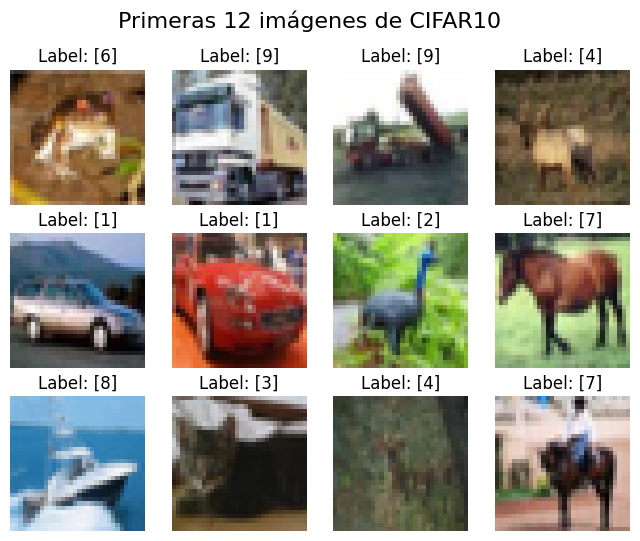

In [11]:
cant = 12
indices = list(range(0, cant, 1))
plot_images(x_train_cifar10,y_train_cifar10, indices,"Primeras " +str(cant)+ " imágenes de CIFAR10")

## Contar las ocurrencias de cada etiqueta en el conjunto de entrenamiento

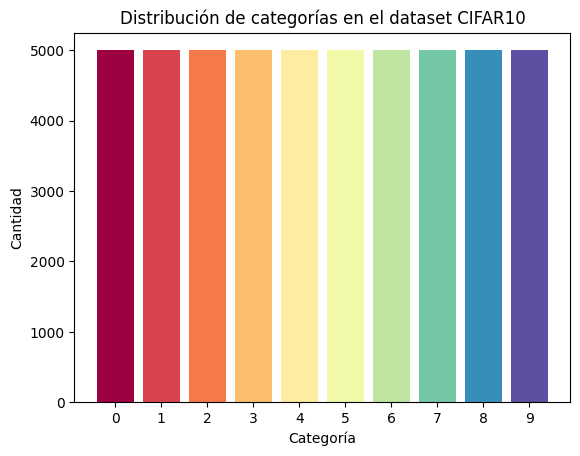

In [13]:
def plot_category_distribution(labels, title, category_names=None):
    # Calcula la cantidad de cada categoría
    unique, counts = np.unique(labels, return_counts=True)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique)))
    # Configura la figura
    fig, ax = plt.subplots()
    ax.bar(unique, counts, color=colors)
    ax.set_xticks(unique)
    if category_names:
        ax.set_xticklabels([category_names[i] for i in unique], rotation=45)
    else:
        ax.set_xticklabels(unique)
    ax.set_title(title)
    ax.set_xlabel('Categoría')
    ax.set_ylabel('Cantidad')
    plt.show()

# Ejemplo de uso con el dataset MNIST
plot_category_distribution(y_train_cifar10, 'Distribución de categorías en el dataset CIFAR10')


In [15]:
y_train_cifar10 = to_categorical(y_train_cifar10, 10)
y_test_cifar10 = to_categorical(y_test_cifar10, 10)

In [16]:
y_train_cifar10

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Modelos de Aprendizaje Automático

## Registro de los modelos

Utilizaré un DataFrame, para almacenar los resultados de ejecución de cada modelo durante su ejecución, y otro con las predicciones

In [17]:
resultados = pd.DataFrame(columns=['Dataset', 'Modelo','Descripcion', 'Accuracy'])
predicciones = {}

## Evaluación de los Modelos
Para garantizar un código eficiente y fácil de mantener en mi proyecto de análisis de modelos de aprendizaje automático, desarrollé una función genérica denominada `evaluate_model`. Esta función me permite evaluar cualquier modelo de clasificación y visualizar sus resultados de manera estandarizada. Su propósito es realizar predicciones con el modelo proporcionado, generar un reporte de clasificación detallado y visualizar una matriz de confusión.

La función `evaluate_model` recibe varios argumentos: el modelo entrenado (`model`), los datos de prueba (`X_test`), las etiquetas reales de los datos de prueba (`y_test`), un nombre descriptivo para el modelo (`model_name`), y el nombre del conjunto de datos (`dataset_name`). Con estos inputs, la función ejecuta el siguiente proceso:

* **Predicción**: Utiliza el modelo para predecir las etiquetas de los datos de prueba.
* **Reporte de Clasificación**: Calcula y muestra un informe de clasificación utilizando `classification_report` de scikit-learn, que proporciona métricas como precisión, recall y f1-score por clase, lo cual es crucial para entender el rendimiento del modelo en detalle.
* **Matriz de Confusión**: Genera y visualiza una matriz de confusión usando la biblioteca `seaborn`. Esta matriz es esencial para visualizar cómo las predicciones se comparan con las etiquetas reales, permitiéndome identificar rápidamente las clases que el modelo predice correctamente y aquellas donde se equivoca.

Además esta función retorna los valores predichos, por si es necesario utilziar posteriormente

In [36]:
def evaluate_model(model, X_test, y_test, model_name, dataset_name, viz=True):
    """
    Función para evaluar un modelo y visualizar la matriz de confusión.
    Args:
    - model: modelo entrenado
    - X_test: datos de prueba (features)
    - y_test: etiquetas reales de los datos de prueba
    - model_name: nombre del modelo (para títulos)
    - dataset_name: nombre del dataset (para títulos)
    - viz: booleano para determinar si se visualiza la matriz de confusión
    """
    # Predicción con el modelo
    predictions = model.predict(X_test)

    # Convertir predicciones y etiquetas reales a etiquetas categóricas si es necesario
    predictions = np.argmax(predictions, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    if viz:
        # Generar el reporte de clasificación
        report = classification_report(y_test_labels, predictions)
        print(f"Reporte de Clasificación para el Modelo: {model_name} sobre el DataSet: {dataset_name}:\n{report}")

        # Crear y visualizar la matriz de confusión
        cm = confusion_matrix(y_test_labels, predictions)
        plt.figure(figsize=(7, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Matriz de Confusión para el Modelo: {model_name} sobre el DataSet: {dataset_name}")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()

    acc = accuracy_score(y_test_labels, predictions)

    # Crear un DataFrame con los resultados de esta ejecución
    resultados_nuevos = pd.DataFrame({
        'Dataset': [dataset_name],
        'Modelo': [model_name],
        'Descripcion': [str(model)],  # Usar str(model) para obtener la descripción del modelo
        'Accuracy': [acc]
    })

    # Guardar los resultados en el DataFrame global
    global resultados
    resultados = pd.concat([resultados, resultados_nuevos], ignore_index=True)

    return predictions


En caso de ya tener los modelos ejecutados y almacenados, dirigirse a la sección de __Carga de modelos almacenados__

## Modelos de Caja Negra

### Implementación de una Red Neuronal Convolucional (CNN) para CIFAR10
Para abordar la clasificación de imágenes con una Red Neuronal Convolucional (CNN) en el dataset de CIFAR10, diseñaré y entrenaré un modelo CNN utilizando TensorFlow y Keras. Las CNNs son especialmente adecuadas para el procesamiento de imágenes debido a su capacidad para capturar patrones espaciales y jerárquicos a través de sus filtros convolucionales.

Utilizaré Keras para construir una CNN básica que incluya capas convolucionales, capas de activación ReLU, y capas de pooling para reducir la dimensionalidad mientras se preservan las características importantes.

In [20]:
def create_cnn_model(complexity='simple', input_shape=(32, 32, 3), num_classes=10):
    """
    Función para crear una red neuronal convolucional (CNN) según la complejidad especificada.
    Args:
    - complexity: nivel de complejidad de la red ('simple', 'intermediate', 'complex')
    - input_shape: forma de los datos de entrada (alto, ancho, canales)
    - num_classes: número de clases para la clasificación
    Returns:
    - model: modelo CNN creado
    """
    model = Sequential()

    if complexity == 'simple':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))

    elif complexity == 'intermediate':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

    elif complexity == 'complex':
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

    else:
        raise ValueError("Complexity must be 'simple', 'intermediate', or 'complex'.")

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### Modelo Simple

In [26]:
# Crear un modelo CNN simple
model_simple = create_cnn_model(complexity='simple', input_shape=(32, 32, 3), num_classes=10)
# Entrenar el modelo
history_model_simple = model_simple.fit(x_train_cifar10, y_train_cifar10, epochs=10,validation_split=0.1, verbose = 1)

Epoch 1/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.4713 - accuracy: 0.4770 - val_loss: 1.2760 - val_accuracy: 0.5528
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.1832 - accuracy: 0.5856 - val_loss: 1.1697 - val_accuracy: 0.5910
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0641 - accuracy: 0.6258 - val_loss: 1.1155 - val_accuracy: 0.6064
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.9833 - accuracy: 0.6533 - val_loss: 1.0627 - val_accuracy: 0.6344
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9149 - accuracy: 0.6806 - val_loss: 1.0548 - val_accuracy: 0.6362
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8502 - accuracy: 0.7034 - val_loss: 1.0820 - val_accuracy: 0.6300
Epoch 7/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7958 - accuracy: 0.7222 - val_loss: 1.0409 - val_accuracy:

In [27]:
model_simple.save('model_simple.keras')

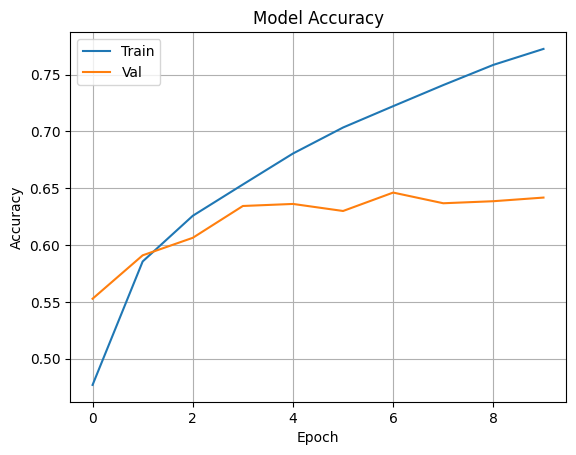

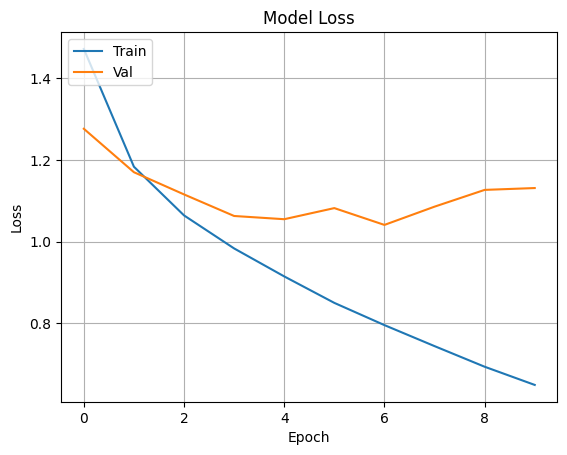

In [28]:
plt.plot(history_model_simple.history['accuracy'])
plt.plot(history_model_simple.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history_model_simple.history['loss'])
plt.plot(history_model_simple.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 [==============================] - 1s 2ms/step
Reporte de Clasificación para el Modelo: CNN sobre el DataSet: CIFAR10:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1000
           1       0.69      0.80      0.74      1000
           2       0.49      0.50      0.49      1000
           3       0.50      0.33      0.40      1000
           4       0.58      0.60      0.59      1000
           5       0.53      0.51      0.52      1000
           6       0.71      0.74      0.72      1000
           7       0.79      0.62      0.69      1000
           8       0.68      0.78      0.73      1000
           9       0.67      0.70      0.69      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.62     10000
weighted avg       0.63      0.63      0.62     10000



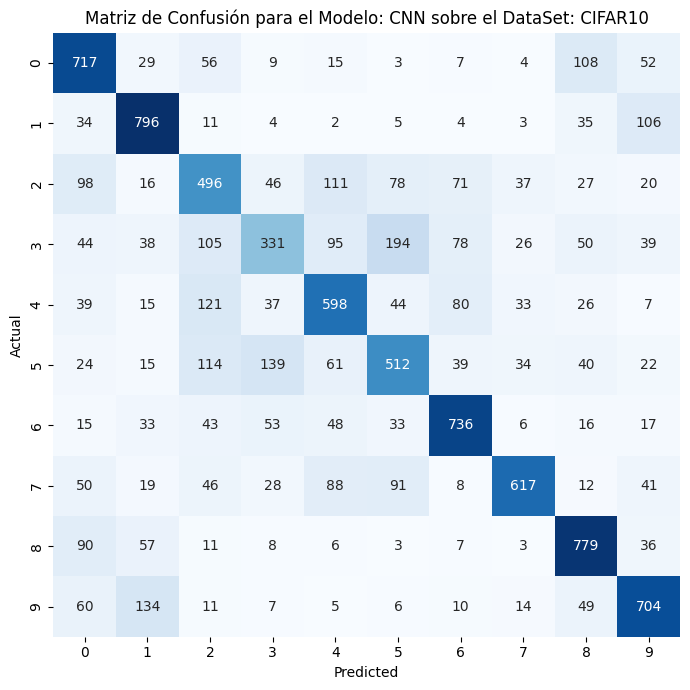

In [37]:
y_pred_simple_cifar10 = evaluate_model(model_simple, x_test_cifar10, y_test_cifar10, "CNN", "CIFAR10")

### Modelo Intermedio

In [29]:
# Crear un modelo CNN intermedio
model_intermediate = create_cnn_model(complexity='intermediate', input_shape=(32, 32, 3), num_classes=10)
# Entrenar el modelo
history_model_intermediate = model_intermediate.fit(x_train_cifar10, y_train_cifar10, epochs=10, validation_split=0.1, verbose = 1)


Epoch 1/10
1407/1407 [==============================] - 11s 5ms/step - loss: 1.5423 - accuracy: 0.4392 - val_loss: 1.2443 - val_accuracy: 0.5630
Epoch 2/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.1971 - accuracy: 0.5745 - val_loss: 1.0292 - val_accuracy: 0.6392
Epoch 3/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0618 - accuracy: 0.6267 - val_loss: 0.9691 - val_accuracy: 0.6652
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.9783 - accuracy: 0.6588 - val_loss: 0.8930 - val_accuracy: 0.6942
Epoch 5/10
1407/1407 [==============================] - 9s 7ms/step - loss: 0.9063 - accuracy: 0.6819 - val_loss: 0.8549 - val_accuracy: 0.7098
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8497 - accuracy: 0.7002 - val_loss: 0.8696 - val_accuracy: 0.7090
Epoch 7/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8023 - accuracy: 0.7186 - val_loss: 0.8607 - val_accurac

In [30]:
model_intermediate.save('model_intermediate.keras')

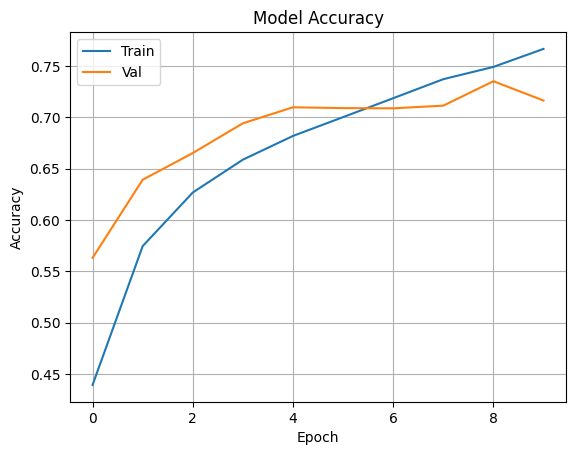

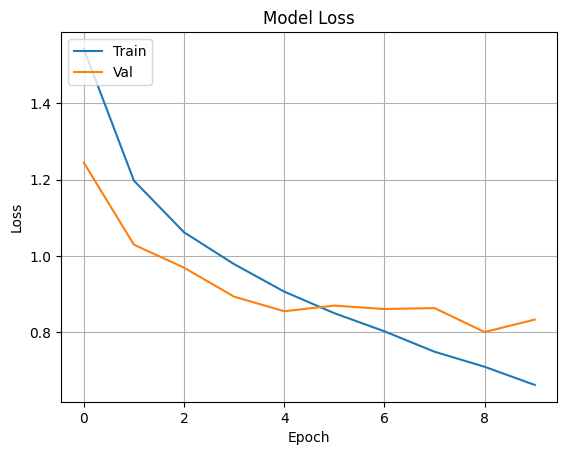

In [31]:
plt.plot(history_model_intermediate.history['accuracy'])
plt.plot(history_model_intermediate.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history_model_intermediate.history['loss'])
plt.plot(history_model_intermediate.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 [==============================] - 1s 4ms/step
Reporte de Clasificación para el Modelo: CNN sobre el DataSet: CIFAR10:
              precision    recall  f1-score   support

           0       0.66      0.83      0.73      1000
           1       0.86      0.78      0.82      1000
           2       0.55      0.65      0.60      1000
           3       0.55      0.46      0.50      1000
           4       0.67      0.62      0.64      1000
           5       0.64      0.57      0.60      1000
           6       0.84      0.69      0.76      1000
           7       0.68      0.81      0.74      1000
           8       0.79      0.80      0.80      1000
           9       0.79      0.79      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



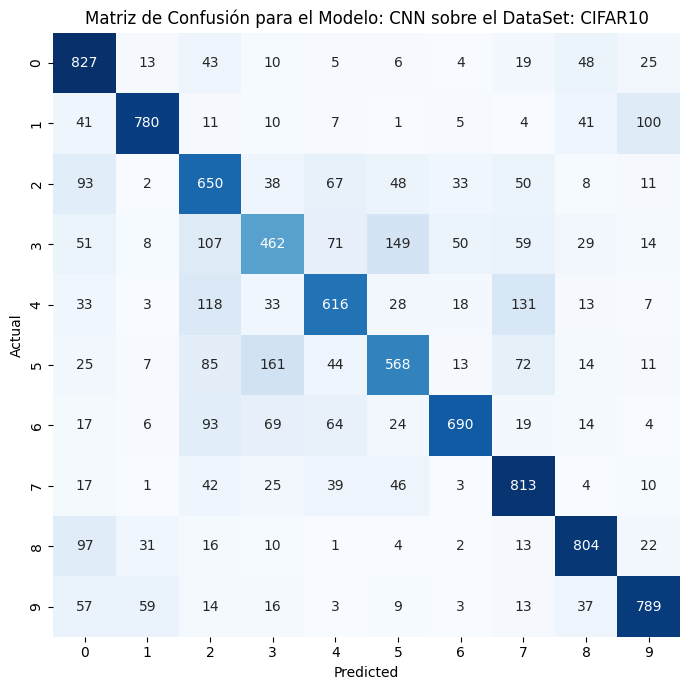

In [38]:
y_pred_intermediate_cifar10 = evaluate_model(model_intermediate, x_test_cifar10, y_test_cifar10, "CNN", "CIFAR10")

### Modelo Complejo

In [32]:

# Crear un modelo CNN complejo
model_complex = create_cnn_model(complexity='complex', input_shape=(32, 32, 3), num_classes=10)
# Entrenar el modelo
history_model_complex = model_complex.fit(x_train_cifar10, y_train_cifar10, epochs=10, validation_split=0.1, verbose = 1)

Epoch 1/10
1407/1407 [==============================] - 11s 6ms/step - loss: 1.6628 - accuracy: 0.3798 - val_loss: 1.4404 - val_accuracy: 0.4848
Epoch 2/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.2753 - accuracy: 0.5440 - val_loss: 1.0745 - val_accuracy: 0.6188
Epoch 3/10
1407/1407 [==============================] - 14s 10ms/step - loss: 1.1113 - accuracy: 0.6125 - val_loss: 0.9617 - val_accuracy: 0.6664
Epoch 4/10
1407/1407 [==============================] - 13s 9ms/step - loss: 0.9980 - accuracy: 0.6539 - val_loss: 0.9163 - val_accuracy: 0.6846
Epoch 5/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.9165 - accuracy: 0.6822 - val_loss: 0.8857 - val_accuracy: 0.6916
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.8503 - accuracy: 0.7056 - val_loss: 0.8752 - val_accuracy: 0.6936
Epoch 7/10
1407/1407 [==============================] - 14s 10ms/step - loss: 0.7901 - accuracy: 0.7278 - val_loss: 1.0199 - val_

In [33]:
model_complex.save('model_complex.keras')

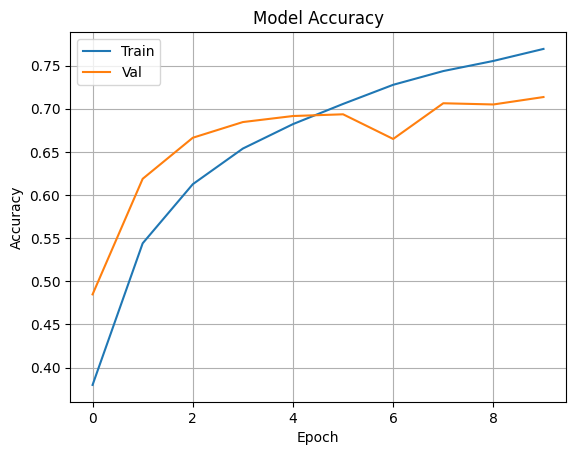

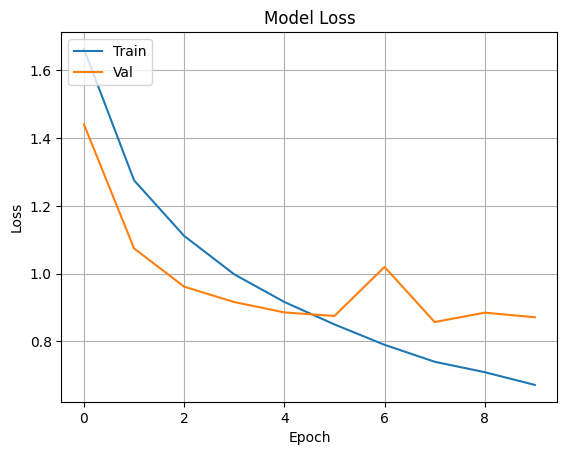

In [34]:
plt.plot(history_model_complex.history['accuracy'])
plt.plot(history_model_complex.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history_model_complex.history['loss'])
plt.plot(history_model_complex.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 [==============================] - 2s 5ms/step
Reporte de Clasificación para el Modelo: CNN sobre el DataSet: CIFAR10:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1000
           1       0.83      0.83      0.83      1000
           2       0.71      0.45      0.55      1000
           3       0.52      0.53      0.52      1000
           4       0.62      0.69      0.65      1000
           5       0.61      0.60      0.61      1000
           6       0.72      0.84      0.78      1000
           7       0.72      0.76      0.74      1000
           8       0.79      0.81      0.80      1000
           9       0.74      0.83      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



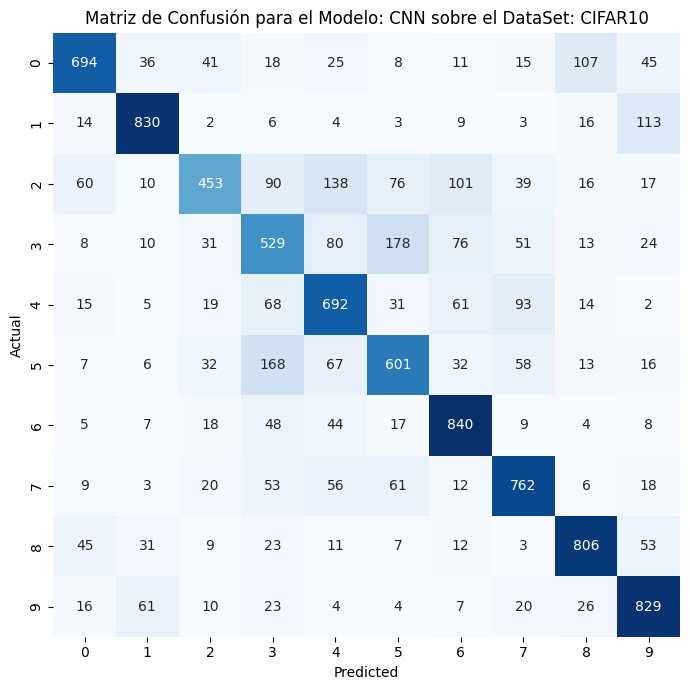

In [39]:
y_pred_complex_cifar10 = evaluate_model(model_complex, x_test_cifar10, y_test_cifar10, "CNN", "CIFAR10")

### Modelo Improve

In [171]:
from tensorflow.keras.layers import BatchNormalization

def create_improved_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_improved = create_improved_cnn_model()
history_improved = model_improved.fit(x_train_cifar10, y_train_cifar10, epochs=20, validation_split=0.1, verbose=1)


Epoch 1/20
1407/1407 [==============================] - 12s 6ms/step - loss: 1.5297 - accuracy: 0.4689 - val_loss: 1.3426 - val_accuracy: 0.5288
Epoch 2/20
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1287 - accuracy: 0.6037 - val_loss: 1.0569 - val_accuracy: 0.6342
Epoch 3/20
1407/1407 [==============================] - 9s 6ms/step - loss: 0.9607 - accuracy: 0.6660 - val_loss: 1.2803 - val_accuracy: 0.5646
Epoch 4/20
1407/1407 [==============================] - 8s 5ms/step - loss: 0.8393 - accuracy: 0.7107 - val_loss: 1.3540 - val_accuracy: 0.5622
Epoch 5/20
1407/1407 [==============================] - 8s 6ms/step - loss: 0.7542 - accuracy: 0.7403 - val_loss: 0.9015 - val_accuracy: 0.7000
Epoch 6/20
1407/1407 [==============================] - 8s 6ms/step - loss: 0.6753 - accuracy: 0.7686 - val_loss: 1.0491 - val_accuracy: 0.6562
Epoch 7/20
1407/1407 [==============================] - 8s 6ms/step - loss: 0.5999 - accuracy: 0.7944 - val_loss: 0.7645 - val_accuracy

In [181]:
model_improved.save('/content/modelos/model_improved.keras')

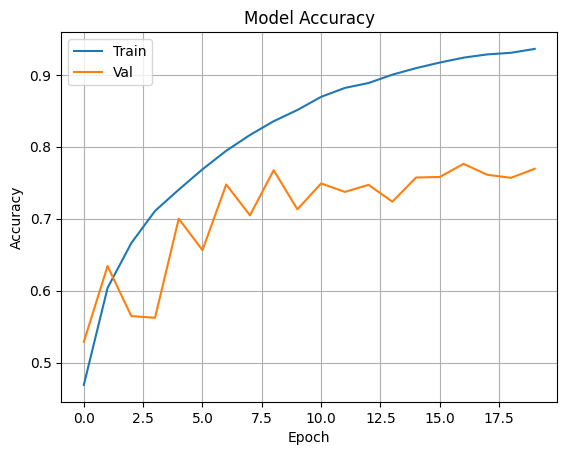

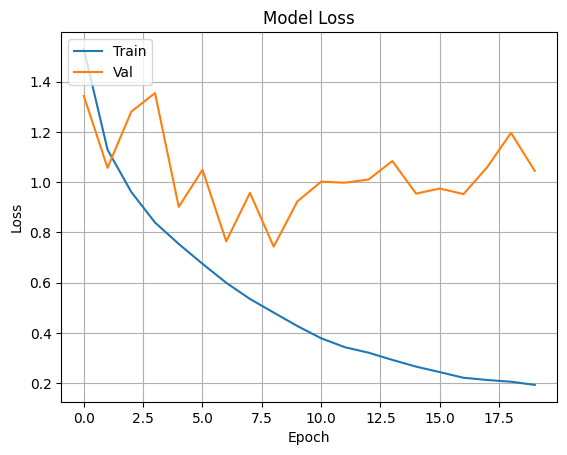

In [173]:
plt.plot(history_improved.history['accuracy'])
plt.plot(history_improved.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history_improved.history['loss'])
plt.plot(history_improved.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.grid()
plt.show()

313/313 [==============================] - 1s 2ms/step
Reporte de Clasificación para el Modelo: CNN sobre el DataSet: CIFAR10:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1000
           1       0.89      0.87      0.88      1000
           2       0.65      0.70      0.67      1000
           3       0.60      0.58      0.59      1000
           4       0.67      0.79      0.72      1000
           5       0.79      0.58      0.67      1000
           6       0.82      0.82      0.82      1000
           7       0.81      0.80      0.81      1000
           8       0.80      0.87      0.83      1000
           9       0.77      0.86      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



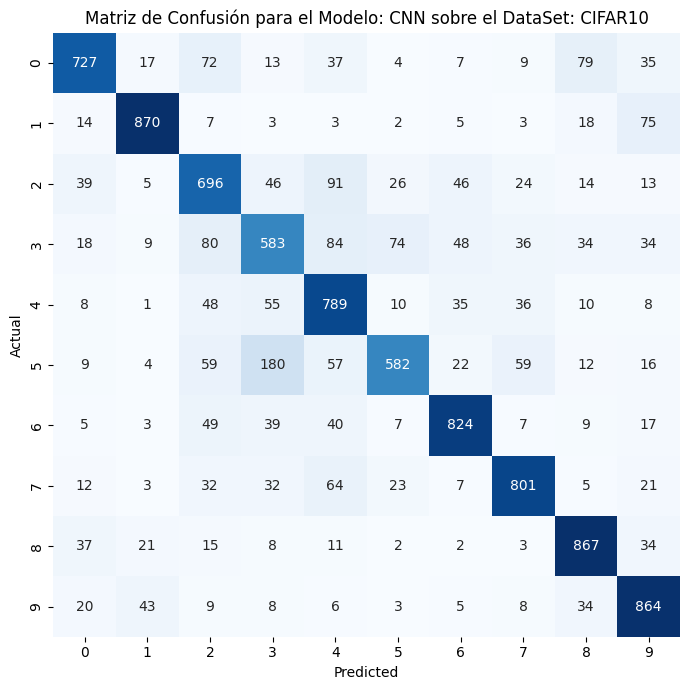

In [176]:
y_pred_improved_cifar10 = evaluate_model(model_improved, x_test_cifar10, y_test_cifar10, "CNN", "CIFAR10")

In [191]:
predicciones['model_simple'] = y_pred_simple_cifar10
predicciones['model_intermediate'] = y_pred_intermediate_cifar10
predicciones['model_complex'] = y_pred_complex_cifar10
predicciones['model_improved'] = y_pred_improved_cifar10

In [192]:
predicciones

{'simple_cifar10': array([3, 8, 0, ..., 2, 1, 7]),
 'intermediate_cifar10': array([3, 8, 8, ..., 5, 4, 7]),
 'complex_cifar10': array([3, 8, 8, ..., 5, 1, 7]),
 'model_simple': array([3, 8, 0, ..., 2, 1, 7]),
 'model_intermediate': array([3, 8, 8, ..., 5, 4, 7]),
 'model_complex': array([3, 8, 8, ..., 5, 1, 7]),
 'model_improved': array([3, 1, 8, ..., 5, 1, 7])}

In [193]:
with open('prediccionesnuevo.pkl', 'wb') as f:
    pickle.dump(predicciones, f)

In [183]:
resultados.sort_values(by=['Dataset', 'Accuracy'], ascending=[False, False])

,Dataset,Modelo,Descripcion,Accuracy
3,CIFAR10,CNN,<keras.src.engine.sequential.Sequential object...,0.7603
2,CIFAR10,CNN,<keras.src.engine.sequential.Sequential object...,0.7036
1,CIFAR10,CNN,<keras.src.engine.sequential.Sequential object...,0.6999
0,CIFAR10,CNN,<keras.src.engine.sequential.Sequential object...,0.6286


## Carga de modelos y predicciones almacenadas

Esto lo hago debido a que la ejecución de cada modelo tarda un tiempo considerable, de esta manera en caso de perder la ejecución del entorno, se podría volver a levantar cada uno de ellos y no ejecutarlo nuevamente, como así también las predicciones de cada modelo.

### Identificar los Archivos de Modelo y cargarlos en Diccionario
Primero, listar todos los archivos de modelo en un directorio específico. Esto se puede hacer usando la biblioteca `os`, además de cargarlos en un diccionario:

In [184]:
# Directorio donde están almacenados los modelos
model_dir = '/content/modelos'

# Diccionario para almacenar los modelos
models = {}

# Cargar los modelos y almacenarlos en el diccionario
for file in os.listdir(model_dir):
    if file.endswith('.keras') or file.endswith('.joblib'):
        file_path = os.path.join(model_dir, file)
        model_name = file.split('.')[0]  # Elimina la extensión del archivo para usar como clave del diccionario
        if file.endswith('.keras'):
            models[model_name] = load_model(file_path)
        elif file.endswith('.joblib'):
            models[model_name] = load(file_path)
        else:
            print(f"Modelo no soportado para el archivo: {file}")

In [185]:
models

{'model_complex': <keras.src.engine.sequential.Sequential at 0x7a6cdff48e20>,
 'model_simple': <keras.src.engine.sequential.Sequential at 0x7a6cdff4add0>,
 'model_improved': <keras.src.engine.sequential.Sequential at 0x7a6cdffbe890>,
 'model_intermediate': <keras.src.engine.sequential.Sequential at 0x7a6cdff49060>}

In [194]:
with open('prediccionesnuevo.pkl', 'rb') as f:
    predicciones = pickle.load(f)

# Verificar que el diccionario se haya cargado correctamente
predicciones

{'simple_cifar10': array([3, 8, 0, ..., 2, 1, 7]),
 'intermediate_cifar10': array([3, 8, 8, ..., 5, 4, 7]),
 'complex_cifar10': array([3, 8, 8, ..., 5, 1, 7]),
 'model_simple': array([3, 8, 0, ..., 2, 1, 7]),
 'model_intermediate': array([3, 8, 8, ..., 5, 4, 7]),
 'model_complex': array([3, 8, 8, ..., 5, 1, 7]),
 'model_improved': array([3, 1, 8, ..., 5, 1, 7])}

# Predicciones de los Modelos

### Errores en las Predicciones

In [76]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors, labels=None):
    n = 0
    nrows = 1
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 2))
    for col in range(ncols):
        if n < len(errors_index):
            error = errors_index[n]
            ax[col].imshow(img_errors[error])
            if labels is None:
                ax[col].set_title(f"Pred: {pred_errors[error]}\nTrue: {obs_errors[error]}")
            else:
                ax[col].set_title(f"Pred: {labels[pred_errors[error]]} - ({pred_errors[error]})\nTrue: {labels[obs_errors[error]]} - ({obs_errors[error]})")
            n += 1
        else:
            ax[col].axis('off')
    plt.show()

def evaluate_and_display(model, x_test, y_pred, y_test, model_name, labels=None):
    y_test_labels = np.argmax(y_test, axis=1)
    df_nuevo = pd.DataFrame({'pred': y_pred, 'test': y_test_labels})
    mask_df_errores = df_nuevo['pred'] != df_nuevo['test']
    mask_df_correctos = df_nuevo['pred'] == df_nuevo['test']
    indices_errores = df_nuevo[mask_df_errores].tail(6).index
    indices_correctos = df_nuevo[mask_df_correctos].head(15).index
    accuracy = accuracy_score(y_test_labels, y_pred)
    print(f"Accuracy del modelo: {model_name}: {accuracy:.2f}")

    print(f"Predichos incorrectamente por el modelo: {model_name}:")
    display_errors(indices_errores, x_test, y_pred, y_test_labels, labels)

    print(f"Predichos correctamente por el modelo: {model_name}:")
    display_errors(indices_correctos, x_test, y_pred, y_test_labels, labels)

    return indices_errores, indices_correctos

def get_model_type(key):
    return key.split('_')[0].upper()

def use_evaluate_model(models, x_test, y_test):
    results = {}
    y_test_labels = np.argmax(y_test, axis=1)
    for name, model in models.items():
        model_type = get_model_type(name)
        print(f"Evaluando {name} ({model_type})...")

        y_pred = model.predict(x_test)
        y_pred_labels = np.argmax(y_pred, axis=1)

        important_errors, important_corrects = evaluate_and_display(model, x_test, y_pred_labels, y_test, name)

        results[name] = {
            'Mal predichos': important_errors,
            'Bien predichos': important_corrects
        }

    return results

### Llamar a la función para evaluar los modelos y mostrar correctos e incorrectos

In [47]:
models

{}

Evaluando model_complex (MODEL)...
313/313 [==============================] - 1s 2ms/step
Accuracy del modelo: model_complex: 0.70
Predichos incorrectamente por el modelo: model_complex:


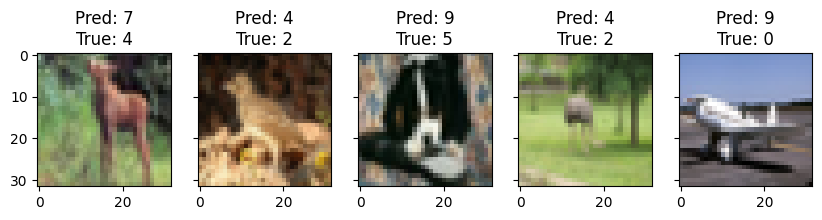

Predichos correctamente por el modelo: model_complex:


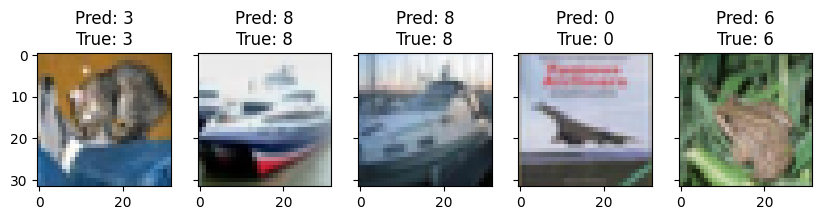

Evaluando model_simple (MODEL)...
313/313 [==============================] - 1s 2ms/step
Accuracy del modelo: model_simple: 0.63
Predichos incorrectamente por el modelo: model_simple:


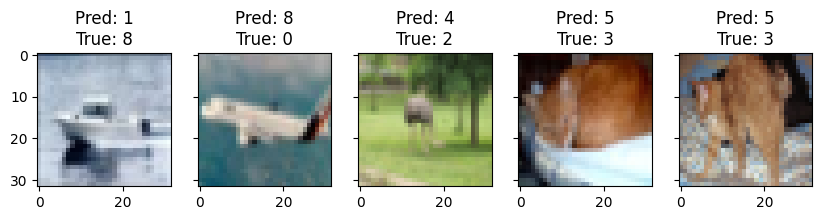

Predichos correctamente por el modelo: model_simple:


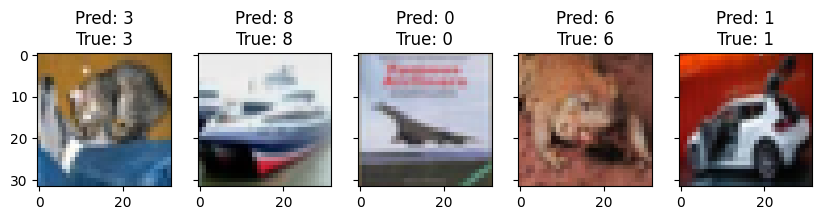

Evaluando model_improved (MODEL)...
313/313 [==============================] - 1s 2ms/step
Accuracy del modelo: model_improved: 0.76
Predichos incorrectamente por el modelo: model_improved:


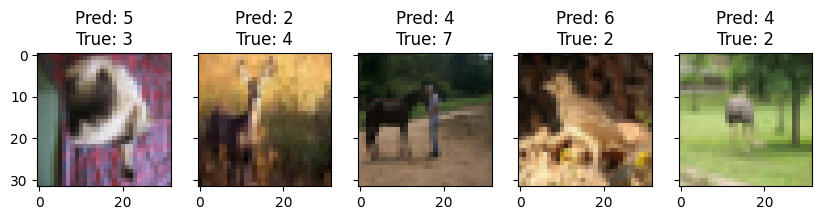

Predichos correctamente por el modelo: model_improved:


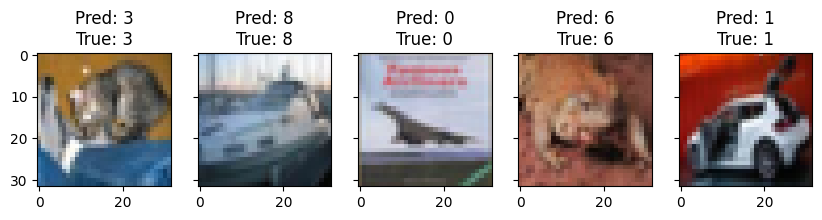

Evaluando model_intermediate (MODEL)...
313/313 [==============================] - 1s 2ms/step
Accuracy del modelo: model_intermediate: 0.70
Predichos incorrectamente por el modelo: model_intermediate:


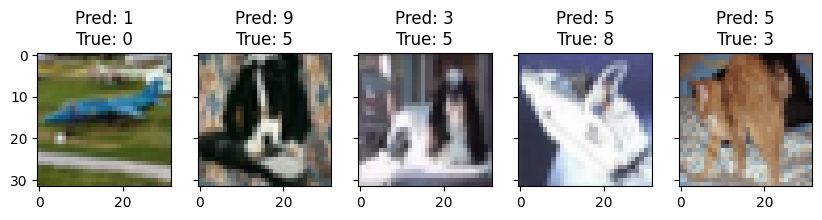

Predichos correctamente por el modelo: model_intermediate:


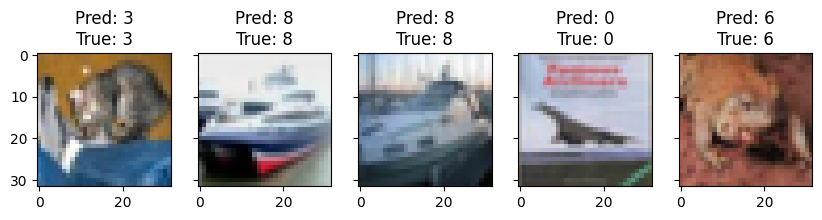

In [195]:
resultados_modelos = use_evaluate_model(models, x_test_cifar10, y_test_cifar10)

In [196]:
resultados_modelos

{'model_complex': {'Mal predichos': Index([9981, 9982, 9985, 9989, 9991, 9993], dtype='int64'),
  'Bien predichos': Index([0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 14, 16, 17, 18], dtype='int64')},
 'model_simple': {'Mal predichos': Index([9986, 9987, 9989, 9992, 9996, 9997], dtype='int64'),
  'Bien predichos': Index([0, 1, 3, 5, 6, 7, 8, 9, 11, 13, 14, 15, 18, 19, 23], dtype='int64')},
 'model_improved': {'Mal predichos': Index([9968, 9972, 9978, 9982, 9989, 9993], dtype='int64'),
  'Bien predichos': Index([0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17], dtype='int64')},
 'model_intermediate': {'Mal predichos': Index([9983, 9985, 9993, 9995, 9996, 9998], dtype='int64'),
  'Bien predichos': Index([0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17], dtype='int64')}}

# Aplicación de Métodos Agnósticos para la Explicabilidad

Para aplicar técnicas de explicabilidad model-agnostic a los modelos entrenados (SVM, RF, MLPClassifier, DNN, CNN), comenzaré por integrar dos de las técnicas más populares y poderosas: LIME (Local Interpretable Model-agnostic Explanations) y SHAP (SHapley Additive exPlanations). Además, exploraré el uso de eli5, una biblioteca que proporciona formas de visualizar y entender las predicciones de los modelos. InterpretML (intercept-community) también puede ser útil dependiendo de las necesidades específicas de explicación y las características de los datos.

## Elección de Técnicas de Explicabilidad
* **LIME**: Permite explicar las predicciones de cualquier clasificador de manera que los humanos puedan entender, mostrando qué características de los datos contribuyen más a la predicción.
* **SHAP**: Utiliza valores de Shapley de la teoría de juegos para estimar cómo cada característica contribuye a la predicción, siendo útil para interpretar tanto modelos globales como predicciones individuales.

### LIME



In [80]:

def explain_instance_with_lime(image, classifier_fn, name_model, val_pred, val_real, model_type='cnn', labels=None, **kwargs):
    explainer = lime_image.LimeImageExplainer()

    # La imagen ya está en formato RGB
    image_rgb = image

    def model_predict(data):
        if model_type == 'flat':
            x_flat = data.reshape(data.shape[0], -1)  # Aplanar las imágenes para modelos de scikit-learn
        else:
            x_flat = data  # Mantener formato de imagen para CNN

        return classifier_fn(x_flat)

    # Explicar la instancia usando LIME y mostrar la imagen original
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Imagen Original")
    plt.axis('off')

    # Generar una explicación de LIME con solo las características positivas
    explanation = explainer.explain_instance(image_rgb, model_predict, top_labels=5, num_samples=50, **kwargs)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("Características Positivas")
    plt.axis('off')

    # Generar una explicación de LIME con todas las características
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("Todas las Características")
    plt.axis('off')

    # Agregar el título de la explicación de LIME
    if labels is None:
        plt.suptitle(f"Explicación de LIME para el Modelo: {name_model} - El modelo dice {val_pred} y es {val_real}")
    else:
        plt.suptitle(f"Explicación de LIME para el Modelo: {name_model} - El modelo dice {labels[val_pred]} y es {labels[val_real]}")
    plt.show()

    # Seleccionar la misma clase explicada en las figuras anteriores
    ind = explanation.top_labels[0]

    # Mapear cada peso de explicación al superpíxel correspondiente
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

    # Mostrar el mapa de calor
    plt.figure(figsize=(4, 4))
    plt.imshow(heatmap, cmap='coolwarm', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title("Mapa de Calor de la Explicación")
    plt.axis('off')
    plt.show()

****************************************
Explicaciones de LIME Mal Predichos - Dataset: CIFAR-10
****************************************
1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


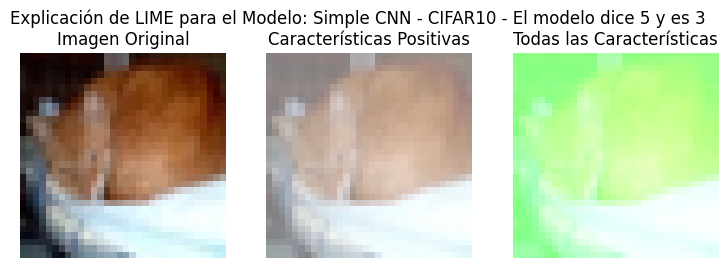

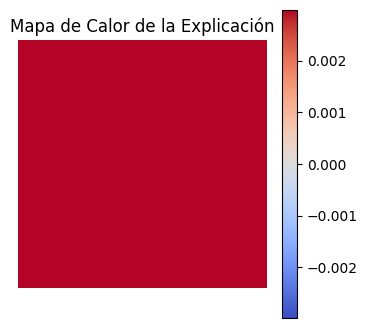

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


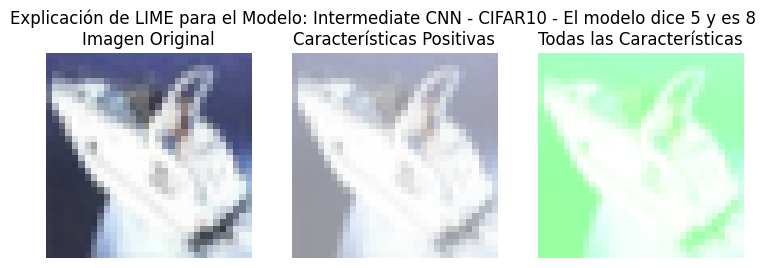

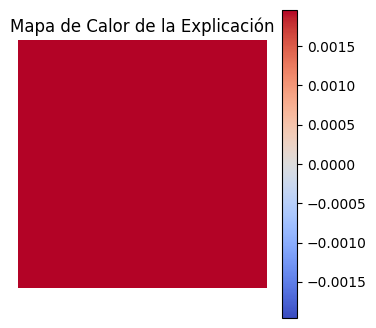

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


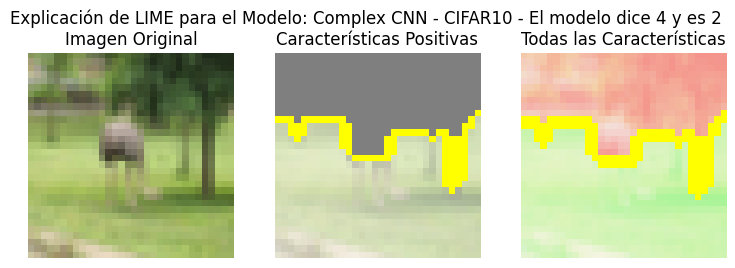

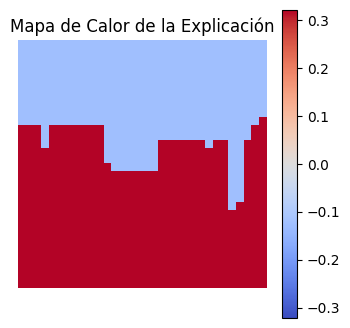

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


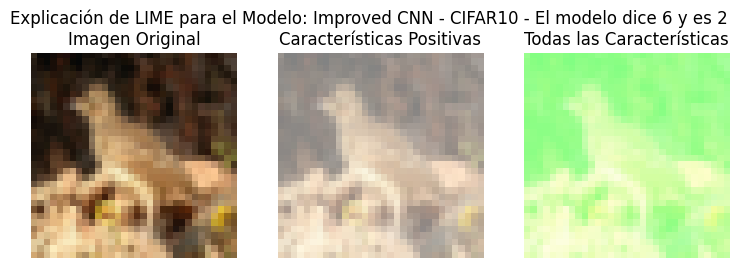

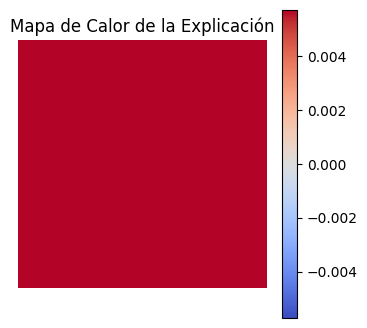

In [200]:
# Ejecutar para cada modelo
modelos = {
    'model_simple': {'name': 'Simple CNN - CIFAR10', 'func': models['model_simple'].predict, 'type': 'image'},
    'model_intermediate': {'name': 'Intermediate CNN - CIFAR10', 'func': models['model_intermediate'].predict, 'type': 'image'},
    'model_complex': {'name': 'Complex CNN - CIFAR10', 'func': models['model_complex'].predict, 'type': 'image'},
    'model_improved': {'name': 'Improved CNN - CIFAR10', 'func': models['model_improved'].predict, 'type': 'image'}
}

print("*" * 40)
print("Explicaciones de LIME Mal Predichos - Dataset: CIFAR-10")
print("*" * 40)

for name, model_info in modelos.items():
    id_imagen = resultados_modelos[name]['Mal predichos'][3]
    image_to_explain = x_test_cifar10[id_imagen]  # Mantener el formato 32x32x3
    val_pred = np.argmax(model_info['func'](x_test_cifar10[id_imagen:id_imagen+1]), axis=1)[0]
    val_real = np.argmax(y_test_cifar10[id_imagen])
    explain_instance_with_lime(
        image_to_explain,
        model_info['func'],
        model_info['name'],
        val_pred,
        val_real,
        model_info['type']
    )


****************************************
Explicaciones de LIME Bien Predichos - Dataset: CIFAR-10
****************************************
1/1 [==============================] - 0s 16ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


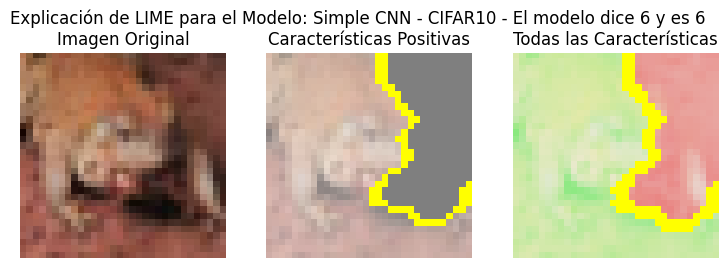

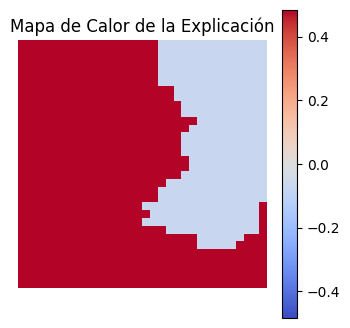

1/1 [==============================] - 0s 25ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


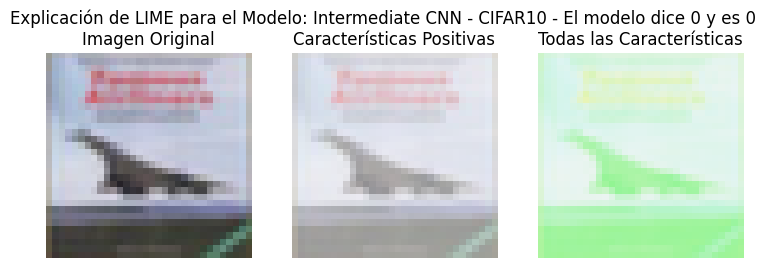

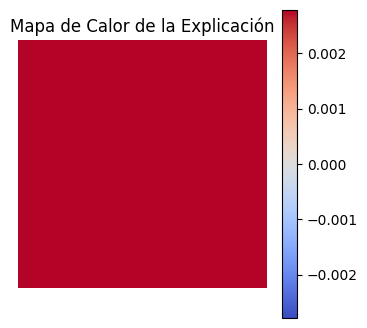

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


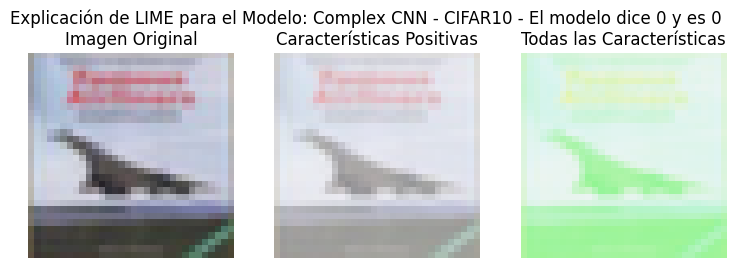

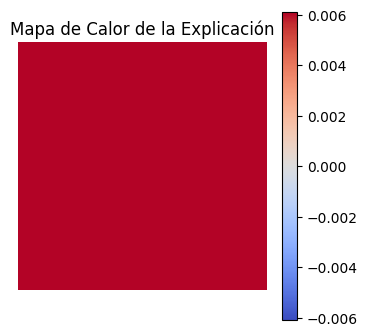

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


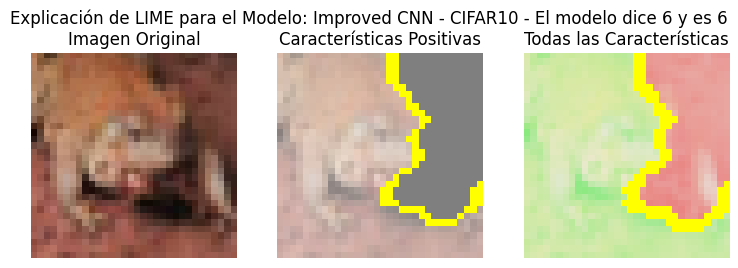

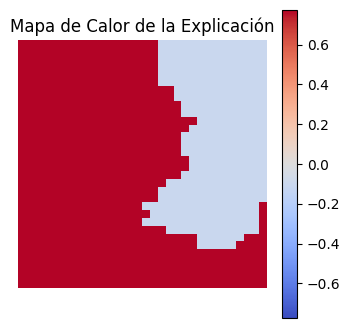

In [201]:


print("*" * 40)
print("Explicaciones de LIME Bien Predichos - Dataset: CIFAR-10")
print("*" * 40)

for name, model_info in modelos.items():
    id_imagen = resultados_modelos[name]['Bien predichos'][3]
    image_to_explain = x_test_cifar10[id_imagen]  # Mantener el formato 32x32x3
    val_pred = np.argmax(model_info['func'](x_test_cifar10[id_imagen:id_imagen+1]), axis=1)[0]
    val_real = np.argmax(y_test_cifar10[id_imagen])
    explain_instance_with_lime(
        image_to_explain,
        model_info['func'],
        model_info['name'],
        val_pred,
        val_real,
        model_info['type']
    )


### SHAP

[(32, 32, 3, 10)]
1/1 [==============================] - 0s 18ms/step


El modelo predice: 4 y realmente es 2


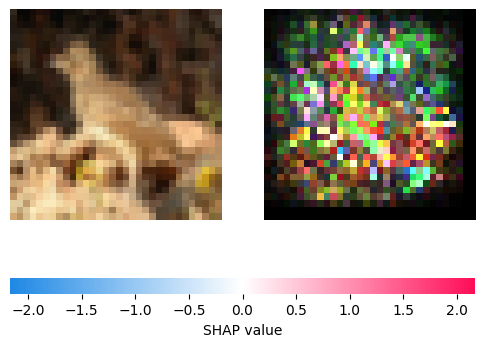

In [207]:
name_model = 'model_complex'
# Selección de la imagen mal predicha
id_imagen = resultados_modelos[name_model]['Mal predichos'][1]
imagen = x_test_cifar10[id_imagen]
input_data = np.expand_dims(imagen, axis=0)

# Cálculo de los valores SHAP
explainer = shap.DeepExplainer(models[name_model], x_train_cifar10[:100])  # Usar una muestra del conjunto de entrenamiento
shap_values = explainer.shap_values(input_data)

# Verificar las formas de los shap_values
print([sv.shape for sv in shap_values])

# Extraer la clase predicha
predicted_class = np.argmax(models[name_model].predict(input_data))

# Configuración de la figura con subplots
print(f"El modelo predice: {predicted_class} y realmente es {np.argmax(y_test_cifar10[id_imagen])}")

# Utilizar shap.image_plot para visualizar los valores SHAP

shap_values = shap_values * 255
mask = (shap_values <0)
shap_values[mask] = 0
shap.image_plot(shap_values, input_data)

[(32, 32, 3, 10)]
1/1 [==============================] - 0s 16ms/step


El modelo predice: 8 y realmente es 8


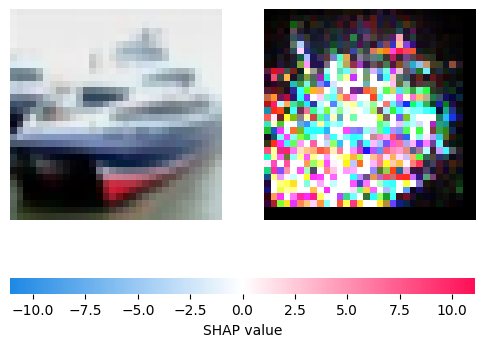

In [209]:

# Selección de la imagen mal predicha
id_imagen = resultados_modelos[name_model]['Bien predichos'][1]
imagen = x_test_cifar10[id_imagen]
input_data = np.expand_dims(imagen, axis=0)

# Cálculo de los valores SHAP
explainer = shap.DeepExplainer(models[name_model], x_train_cifar10[:100])  # Usar una muestra del conjunto de entrenamiento
shap_values = explainer.shap_values(input_data)

# Verificar las formas de los shap_values
print([sv.shape for sv in shap_values])

# Extraer la clase predicha
predicted_class = np.argmax(models[name_model].predict(input_data))

# Configuración de la figura con subplots
print(f"El modelo predice: {predicted_class} y realmente es {np.argmax(y_test_cifar10[id_imagen])}")

# Utilizar shap.image_plot para visualizar los valores SHAP

shap_values = shap_values * 255
mask = (shap_values <0)
shap_values[mask] = 0
shap.image_plot(shap_values, input_data)

In [211]:
for layer in models['model_improved'].layers:
    print(layer.name)


conv2d_7
batch_normalization
max_pooling2d_7
conv2d_8
batch_normalization_1
max_pooling2d_8
conv2d_9
batch_normalization_2
max_pooling2d_9
flatten_4
dense_9
dropout_3
dense_10


In [212]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_gradcam_model(model, layer_name):
    """
    Función para crear un modelo Grad-CAM que devuelve las activaciones y el gradiente del layer deseado.
    Args:
    - model: modelo entrenado
    - layer_name: nombre de la capa que se utilizará para Grad-CAM
    Returns:
    - gradcam_model: modelo que devuelve las activaciones y el gradiente del layer deseado
    """
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    return grad_model

def compute_gradcam(model, image, layer_name):
    """
    Función para calcular Grad-CAM para una imagen dada.
    Args:
    - model: modelo entrenado
    - image: imagen de entrada para la cual se calculará Grad-CAM
    - layer_name: nombre de la capa que se utilizará para Grad-CAM
    Returns:
    - heatmap: mapa de calor de Grad-CAM
    """
    grad_model = get_gradcam_model(model, layer_name)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, np.argmax(predictions[0])]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (image.shape[2], image.shape[1]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap

def show_gradcam(image, heatmap, alpha=0.4):
    """
    Función para mostrar Grad-CAM sobre la imagen original.
    Args:
    - image: imagen original
    - heatmap: mapa de calor de Grad-CAM
    - alpha: factor de transparencia para el mapa de calor
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap * alpha) / 255
    superimposed_img = heatmap + image
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.show()







In [215]:
name_model = 'model_improved'

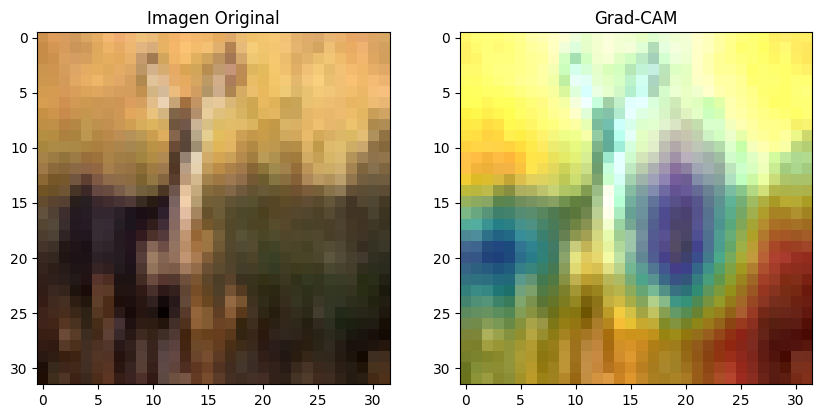

In [218]:
# Selección de la imagen mal predicha
id_imagen = resultados_modelos[name_model]['Mal predichos'][1]
image = x_test_cifar10[id_imagen]
input_data = np.expand_dims(image, axis=0)

# Calcular Grad-CAM usando la capa convolucional correcta
heatmap = compute_gradcam(models[name_model], input_data, 'conv2d_9')

# Mostrar la imagen original y Grad-CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')


plt.subplot(1, 2, 2)
show_gradcam(image, heatmap)

In [147]:
# Imprimir los nombres de las capas del modelo
for layer in models['model_complex'].layers:
    print(layer.name)

conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
flatten_3
dense_6
dropout_1
dense_7
dropout_2
dense_8


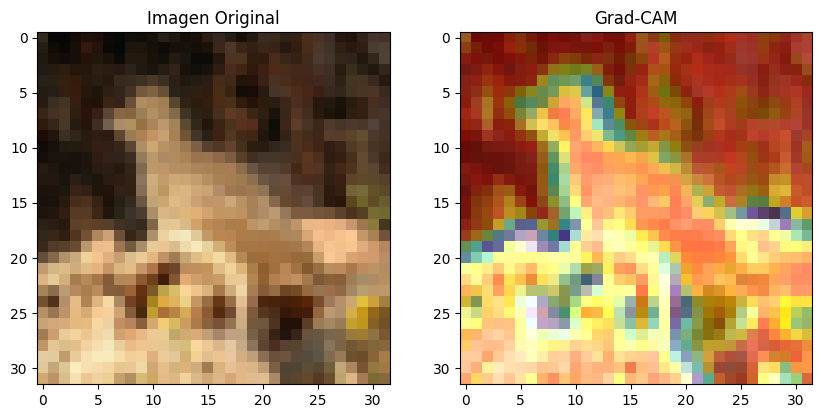

In [150]:
# Selección de la imagen mal predicha
id_imagen = resultados_modelos['model_complex']['Mal predichos'][1]
image = x_test_cifar10[id_imagen]
input_data = np.expand_dims(image, axis=0)

# Calcular Grad-CAM usando la capa convolucional correcta
heatmap = compute_gradcam(models['model_complex'], input_data, 'conv2d_4')

# Mostrar la imagen original y Grad-CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')


plt.subplot(1, 2, 2)
show_gradcam(image, heatmap)

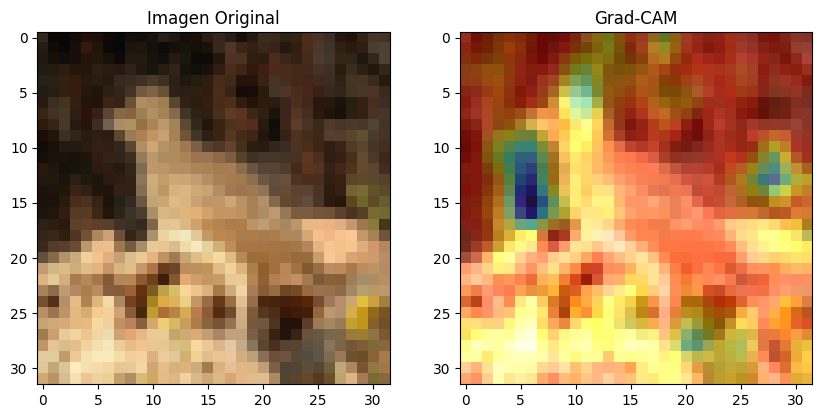

In [151]:
# Calcular Grad-CAM usando la capa convolucional correcta
heatmap = compute_gradcam(models['model_complex'], input_data, 'conv2d_5')

# Mostrar la imagen original y Grad-CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')


plt.subplot(1, 2, 2)
show_gradcam(image, heatmap)

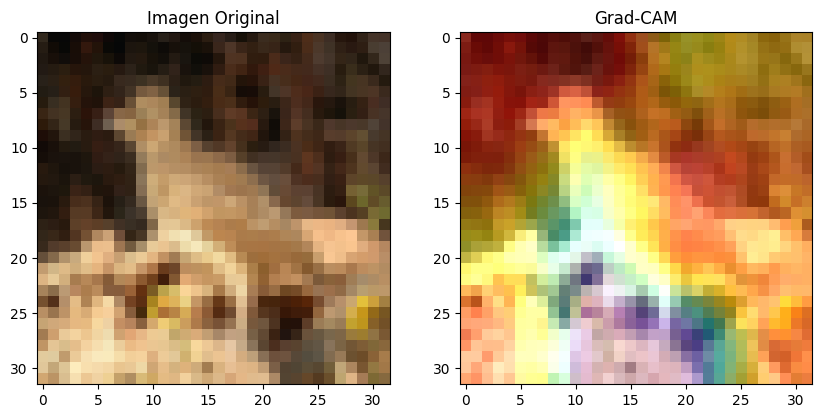

In [152]:
# Calcular Grad-CAM usando la capa convolucional correcta
heatmap = compute_gradcam(models['model_complex'], input_data, 'conv2d_6')

# Mostrar la imagen original y Grad-CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Imagen Original')


plt.subplot(1, 2, 2)
show_gradcam(image, heatmap)

In [158]:
model_complex.get_layer('conv2d_5').output

<KerasTensor: shape=(None, 13, 13, 64) dtype=float32 (created by layer 'conv2d_5')>

Capa: conv2d_4
  Pesos 0: (3, 3, 3, 32)
  Pesos 1: (32,)
Capa: conv2d_5
  Pesos 0: (3, 3, 32, 64)
  Pesos 1: (64,)
Capa: conv2d_6
  Pesos 0: (3, 3, 64, 128)
  Pesos 1: (128,)
Capa: dense_6
  Pesos 0: (512, 512)
  Pesos 1: (512,)
Capa: dense_7
  Pesos 0: (512, 256)
  Pesos 1: (256,)
Capa: dense_8
  Pesos 0: (256, 10)
  Pesos 1: (10,)


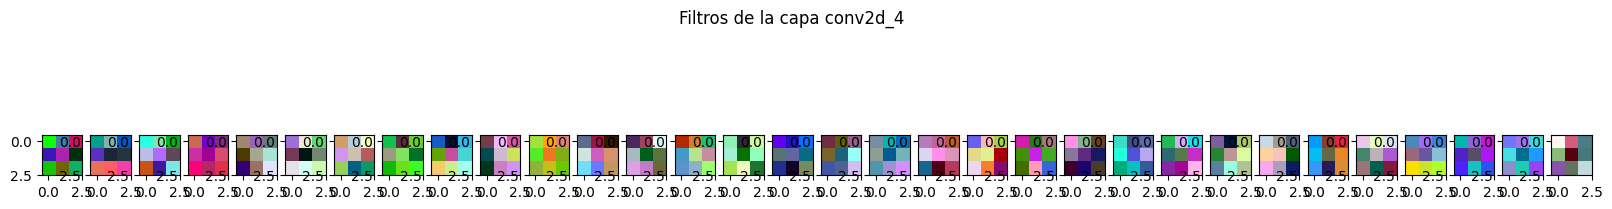

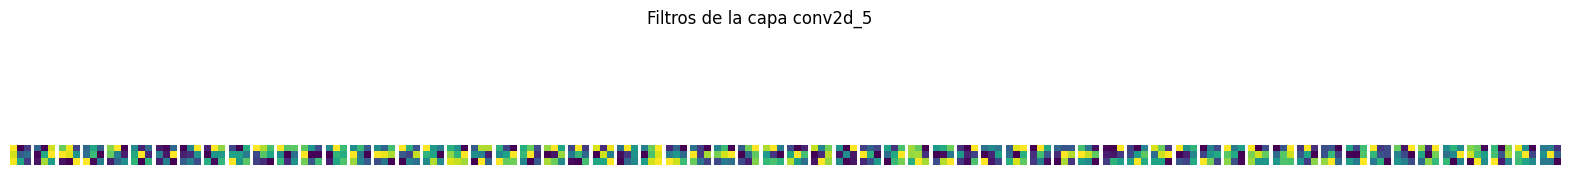

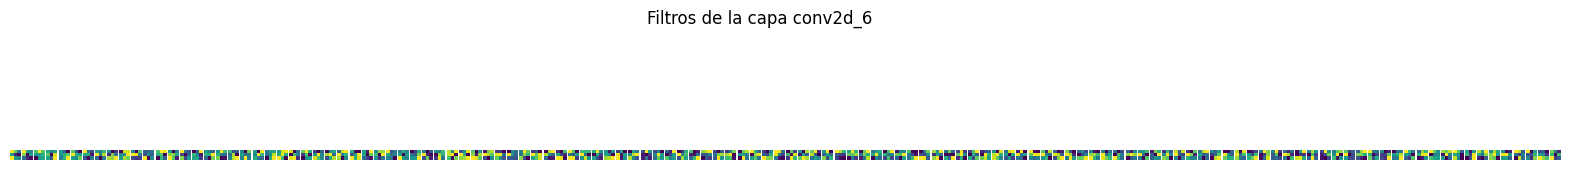

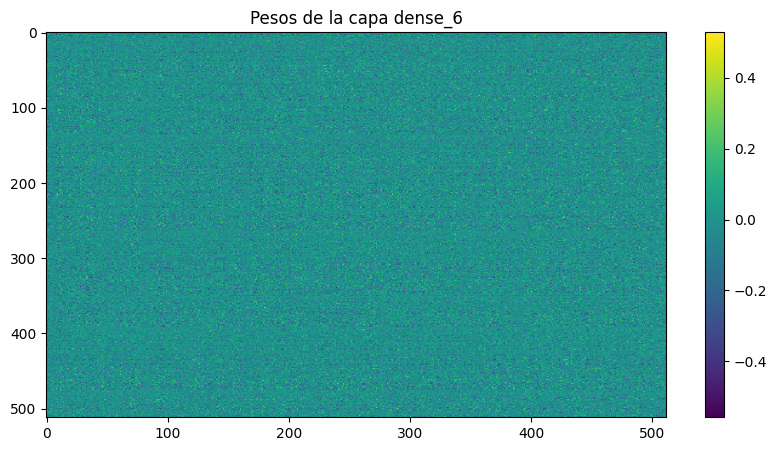

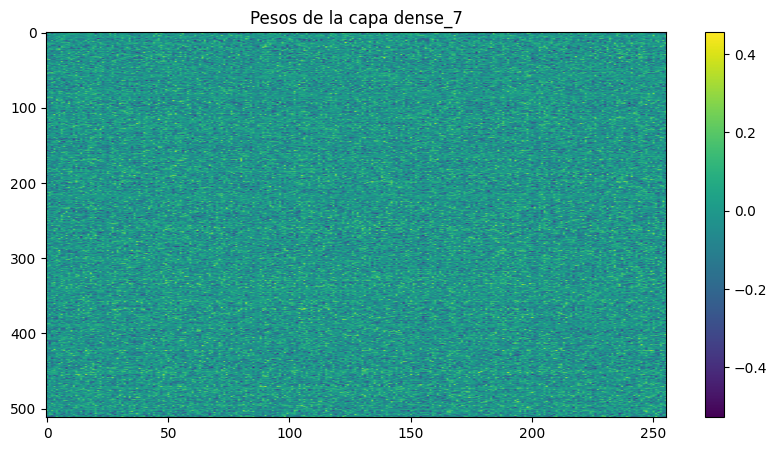

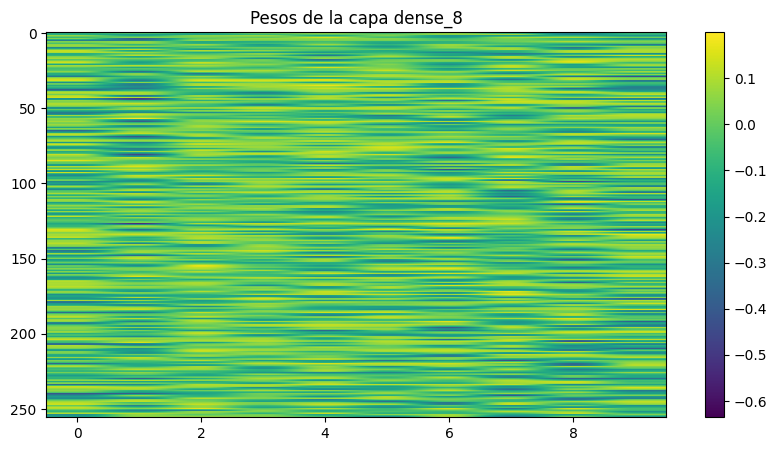

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Función para imprimir los pesos y sesgos de cada capa
def print_weights(model):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Solo capas que tienen pesos
            print(f"Capa: {layer.name}")
            for i, weight in enumerate(weights):
                print(f"  Pesos {i}: {weight.shape}")

# Función para visualizar los filtros de una capa convolucional como imágenes a color
def visualize_conv_weights(weights, title):
    num_filters = weights.shape[-1]
    num_channels = weights.shape[-2]
    fig, axs = plt.subplots(1, num_filters, figsize=(20, 3))
    for i in range(num_filters):
        # Para cada filtro, normalizamos y mostramos como una imagen a color si tiene 3 canales
        filter = weights[:, :, :, i]
        if num_channels == 3:
            filter = (filter - filter.min()) / (filter.max() - filter.min())
            axs[i].imshow(filter)
        else:
            for j in range(num_channels):
                axs[i].imshow(filter[:, :, j], cmap='viridis')
                axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Función para visualizar los pesos de una capa densa como mapa de calor
def visualize_dense_weights(weights, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Imprimir los nombres de las capas y sus pesos
print_weights(models['model_complex'])

# Visualizar los pesos de todas las capas
for layer in models['model_complex'].layers:
    weights = layer.get_weights()
    if weights:  # Solo capas que tienen pesos
        if len(weights[0].shape) == 4:  # Capa convolucional
            visualize_conv_weights(weights[0], f'Filtros de la capa {layer.name}')
        elif len(weights[0].shape) == 2:  # Capa densa
            visualize_dense_weights(weights[0], f'Pesos de la capa {layer.name}')
